In [1]:
import sys
sys.path.append('../')

import os
import subprocess
from glob import glob
import math
from tqdm import tqdm
import pprint
import pandas as pd
import nibabel as nib
from NiftiManager import NiftiManager
import numpy as np
from scipy.stats import pearsonr
from skimage import exposure

pp = pprint.PrettyPrinter(indent=4)
NM = NiftiManager()

##### Helper functions

In [2]:
def excute_cmd(command):
    # excute the command
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)

    # Check the return code to see if the command was successful
    if result.returncode == 0:
        # print("Command executed successfully.")
        # print("Output:")
        return result.stdout
    else:
        print(f"Command failed with an error: {command}")
        print(result.stderr)
        return result.stderr

def create_directory_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def mutual_information(img_reg, img_fixed):
    '''Computes the mutual information metric between two images.'''
    hist_2d, x_edges, y_edges = np.histogram2d(img_reg.astype(np.double).ravel(),
                                           img_fixed.astype(np.double).ravel(),bins=20)
    # Convert bins counts to probability values
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def ncc(img1, img2, negative=False):
    '''Normalized cross-correlation implementation.
    '''
    # calculate the means of each image
    img1_mean = np.mean(img1)
    img2_mean = np.mean(img2)

    # calculate the numerator
    num = np.sum((img1 - img1_mean) * (img2 - img2_mean))

    # calculate the denominator
    p1 = np.sqrt(np.sum((img1 - img1_mean)**2))
    p2 = np.sqrt(np.sum((img2 - img2_mean)**2))
    denum = p1 * p2
    
    result = num / denum

    return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

def perform_histogram_matching(fixed_volume, moving_volume):
    # Ensure the volumes have the same shape
    if fixed_volume.shape != moving_volume.shape:
        raise ValueError("The fixed and moving volumes must have the same shape for histogram matching.")
    
    # Flatten the volumes for histogram matching
    fixed_flat = fixed_volume.ravel()
    moving_flat = moving_volume.ravel()
    
    # Perform histogram matching
    matched_moving_flat = exposure.match_histograms(moving_flat, fixed_flat)
    
    # Reshape the matched moving volume to its original shape
    matched_moving_volume = matched_moving_flat.reshape(moving_volume.shape)
    
    return matched_moving_volume


In [3]:
print(excute_cmd('elastix --help'))

elastix version: 5.000

elastix registers a moving image to a fixed image.
The registration-process is specified in the parameter file.
  --help, -h displays this message and exit
  --version  output version information and exit
  --extended-version  output extended version information and exit

Call elastix from the command line with mandatory arguments:
  -f        fixed image
  -m        moving image
  -out      output directory
  -p        parameter file, elastix handles 1 or more "-p"

Optional extra commands:
  -fMask    mask for fixed image
  -mMask    mask for moving image
  -t0       parameter file for initial transform
  -priority set the process priority to high, abovenormal, normal (default),
            belownormal, or idle (Windows only option)
  -threads  set the maximum number of threads of elastix

The parameter-file must contain all the information necessary for elastix to run properly. That includes which metric to use, which optimizer, which transform, etc. It must 

#### For us to find the best reference frame (fixed image) among the given datasets, we can measure some image quality and similarity metrics such as mutual information, signal to noise ratio (SNR), image sharpness, etc.. 
#### To start with the similarity metrics, as the mutual information, we need to register all images with all possible combinations to see how well images align with all combinations after the registration. The registration will be done using elastix command line, and some helper functions will be developed to ease the process of excuting and registering all images. 

For elastix, we need to specify the parameters files, which for our case will be both Par0010affine.txt and Par0010bspline.txt

In [9]:
reg_params = '-p "Par0010affine.txt" -p "Par0010bspline.txt"'

Experimenting with elastix with the `excute_cmd` function.

In [7]:
reg_fixed  = "training-set/training-images/1000.nii.gz"
reg_moving = "training-set/training-images/1001.nii.gz"
output_dir = f"output/output_{reg_fixed.split('/')[-1].split('.')[0]}/{reg_moving.split('/')[-1].split('.')[0]}"

# create elastix command line
command_line = f'elastix -f {reg_fixed} -m {reg_moving} -p "Par0010affine.txt" -p "Par0010bspline.txt" -out {output_dir}'

# run elastix on all combinations
# print(excute_cmd(command_line))


elastix is started at Mon Oct 30 12:05:49 2023.

which elastix:   elastix
elastix runs at: LAPTOP-KAJKF5BB
  Windows  Personal (x64),  (Build 9200)
  with 16061 MB memory, and 8 cores @ 2496 MHz.
-------------------------------------------------------------------------

Running elastix with parameter file 0: "Par0010affine.txt".

Current time: Mon Oct 30 12:05:50 2023.
Reading the elastix parameters from file ...

Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-f        training-set/training-images/1000.nii.gz
-m        training-set/training-images/1001.nii.gz
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      output\output_1000\1001\
-p        Par0010affine.txt
-p        Par0010bspline.txt
-priority unspecified, so NORMAL process priority
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.

Lets get all images that we have for training

In [10]:
training_path = 'training-set/training-images'

training_volumes = sorted(glob(os.path.join(training_path, "*.nii.gz"), recursive=True))
pprint_objects(training_volumes)

# substract the length as we won't register the images with themselves
print('Total registrations: ', len(training_volumes)*len(training_volumes)-len(training_volumes)) 

(   [   'training-set/training-images\\1000.nii.gz',
        'training-set/training-images\\1001.nii.gz',
        'training-set/training-images\\1002.nii.gz',
        'training-set/training-images\\1006.nii.gz',
        'training-set/training-images\\1007.nii.gz',
        'training-set/training-images\\1008.nii.gz',
        'training-set/training-images\\1009.nii.gz',
        'training-set/training-images\\1010.nii.gz',
        'training-set/training-images\\1011.nii.gz',
        'training-set/training-images\\1012.nii.gz',
        'training-set/training-images\\1013.nii.gz',
        'training-set/training-images\\1014.nii.gz',
        'training-set/training-images\\1015.nii.gz',
        'training-set/training-images\\1017.nii.gz',
        'training-set/training-images\\1036.nii.gz'],)
Total registrations:  210


**Code below registers all images with all possible fixed combinations, run only when needed.**.	

In [11]:
# for fixed in tqdm(training_volumes):
#     for moving in training_volumes:
#         if fixed == moving: # to not register the image with its self
#             continue
            
#         # We register here, every image will be registered with all combinations except its self
#         reg_fixed  = fixed
#         reg_moving = moving

#         # Get the names of the fixed and moving images for the output directory, names without the file extensions
#         reg_fixed_name  = reg_fixed.split("\\")[-1].split(".")[0]
#         reg_moving_name = reg_moving.split("\\")[-1].split(".")[0]
        
#         # create an output folder using the image name in the output/images directory
#         # output folders structures
#         # output_{fixed_img_name}/{moving_image_name}/
#         output_dir = f'output/images/output_{reg_fixed_name}/{reg_moving_name}'

#         # creates the output directory
#         create_directory_if_not_exists(output_dir)

#         # create elastix command line
#         command_line = f'elastix -f "{reg_fixed}" -m "{reg_moving}" {reg_params} -out "{output_dir}"'

#         # run elastix on all combinations
#         excute_cmd(command_line)

 13%|████▏                          | 2/15 [13:48<1:29:21, 412.41s/it]

Command failed with an error: elastix -f "training-set/training-images\1002.nii.gz" -m "training-set/training-images\1006.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1002/1006"

Command failed with an error: elastix -f "training-set/training-images\1002.nii.gz" -m "training-set/training-images\1017.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1002/1017"



 20%|██████▏                        | 3/15 [20:13<1:19:57, 399.81s/it]

Command failed with an error: elastix -f "training-set/training-images\1006.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1006/1002"



 27%|████████▎                      | 4/15 [27:09<1:14:28, 406.20s/it]

Command failed with an error: elastix -f "training-set/training-images\1007.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1007/1002"



 80%|████████████████████████      | 12/15 [1:21:51<20:15, 405.03s/it]

Command failed with an error: elastix -f "training-set/training-images\1015.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1015/1002"



 93%|████████████████████████████  | 14/15 [1:35:02<06:40, 400.40s/it]

Command failed with an error: elastix -f "training-set/training-images\1036.nii.gz" -m "training-set/training-images\1002.nii.gz" -p "Par0010affine.txt" -p "Par0010bspline.txt" -out "output/images/output_1036/1002"



100%|██████████████████████████████| 15/15 [1:41:47<00:00, 407.18s/it]


Some commands has failed, those failed to register will be excluded from the selection of being fixed images.

**Excluding 1002, 1006, 1007, 1015, 1036 from being fixed images as they fail in registering some volumes.**

In [12]:
training_volumes = [
    path for path in training_volumes if not any(name in path for name in ['1002', '1006', '1007', '1015', '1036'])
]
training_volumes

['training-set/training-images\\1000.nii.gz',
 'training-set/training-images\\1001.nii.gz',
 'training-set/training-images\\1008.nii.gz',
 'training-set/training-images\\1009.nii.gz',
 'training-set/training-images\\1010.nii.gz',
 'training-set/training-images\\1011.nii.gz',
 'training-set/training-images\\1012.nii.gz',
 'training-set/training-images\\1013.nii.gz',
 'training-set/training-images\\1014.nii.gz',
 'training-set/training-images\\1017.nii.gz']

##### Calculating the average Mutual Information (MI) for every fixed image registrations. The average is taken to take into accound all of the images being registered in a fixed range, 0 to 1. 

In [ ]:
# mean mutual info list
mean_mutual_info_list = []

# correlation images lists
mean_correlation_list = []

# fixed images lists
fixed_images_list = []

for fixed in tqdm(training_volumes):
    # get the fixed image name
    reg_fixed_name  = fixed.split("\\")[-1].split(".")[0]

    # read the fixed image
    fixed_img, _ = NM.load_nifti(fixed)
    
    # set the output directory
    output_dir = f'output/images/output_{reg_fixed_name}'

    # get the registered volume in each directory
    registered_volumes = sorted(glob(os.path.join(output_dir, '**', "result.1.nii"), recursive=True))

    # mutual information list for each fixed
    mutual_info_list = []

    # correlation list for each fixed
    correlation_list = []

    for moving in registered_volumes:
        # read the moving image
        moving_img, _ = NM.load_nifti(moving)

        # append to a list
        mutual_info_list.append(mutual_information(moving_img, fixed_img))
        correlation_list.append(ncc(moving_img, fixed_img, negative=False))
    
    # compute the mean mutual information
    mean_mutual_info_list.append(np.mean(mutual_info_list))
    fixed_images_list.append(reg_fixed_name)
    mean_correlation_list.append(np.mean(correlation_list))
    
mean_mutual_info_df = pd.DataFrame(mean_mutual_info_list, index=fixed_images_list, columns=["Average Mutual Information (MI)"])
mean_correlation_df = pd.DataFrame(mean_correlation_list, index=fixed_images_list, columns=["Average Normalized Cross-Correlation (NCC)"])

result_df = pd.concat([mean_mutual_info_df, mean_correlation_df], axis=1)
result_df = result_df.sort_values(by="Average Mutual Information (MI)", ascending=False)

result_df

 60%|██▍ | 6/10 [01:59<01:20, 20.05s/it]

**Given the information above for the mean mutual informations, volume 1000 is the most suitable fixed image for building the atlas using Par0010affine.txt and Par0010bspline.txt parameters files .**

In [22]:
# moving

'output_1017\\1036\\result.1.nii'

(256, 287, 256) (256, 287, 256)
0.5216665166926443
float64 4551.52587890625 -181.17950439453125


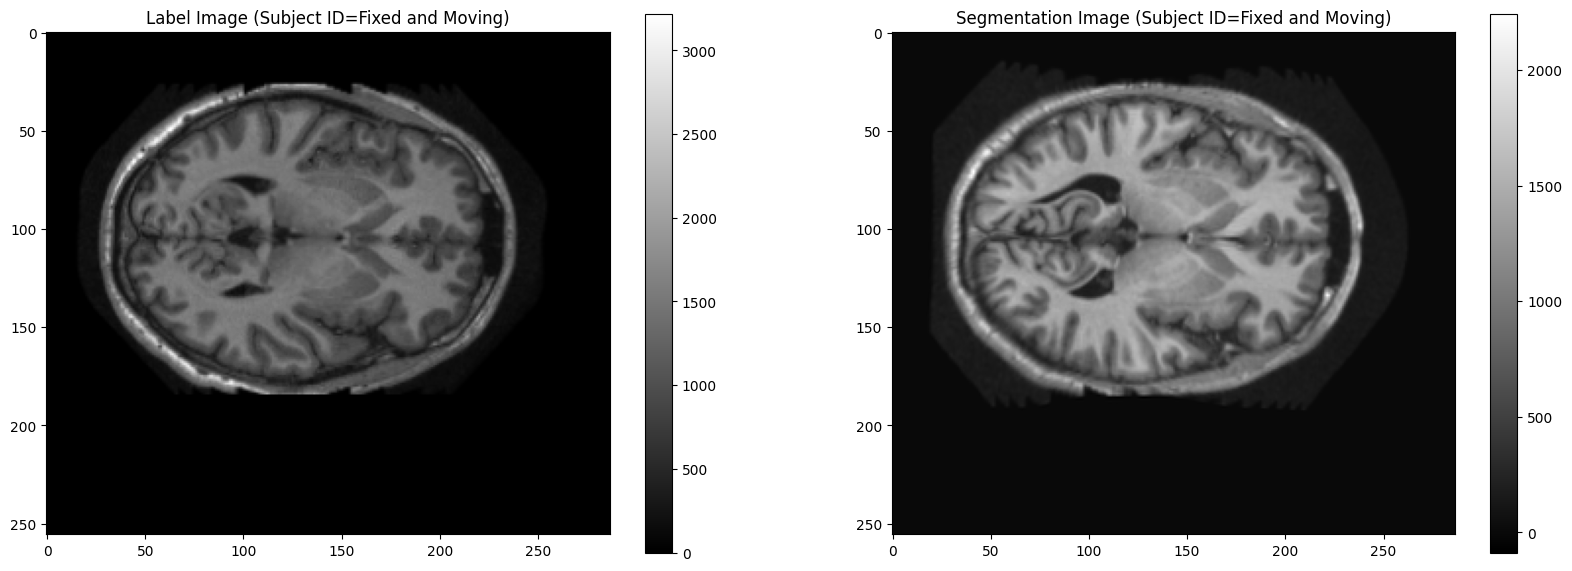

In [40]:
# fixed, _  = NM.load_nifti('../training-set/training-images/1000.nii.gz')
# moving, _ = NM.load_nifti('output_1000/1036/result.1.nii') 

# print(fixed.shape, moving.shape)
# print(mutual_information(moving, fixed))
# print(moving.dtype, np.max(moving), np.min(moving))

# NM.show_label_seg_nifti(fixed, moving, "Fixed and Moving", slice=128)

(256, 287, 256)
0.4953782177417161
float64 4010.0 0.0


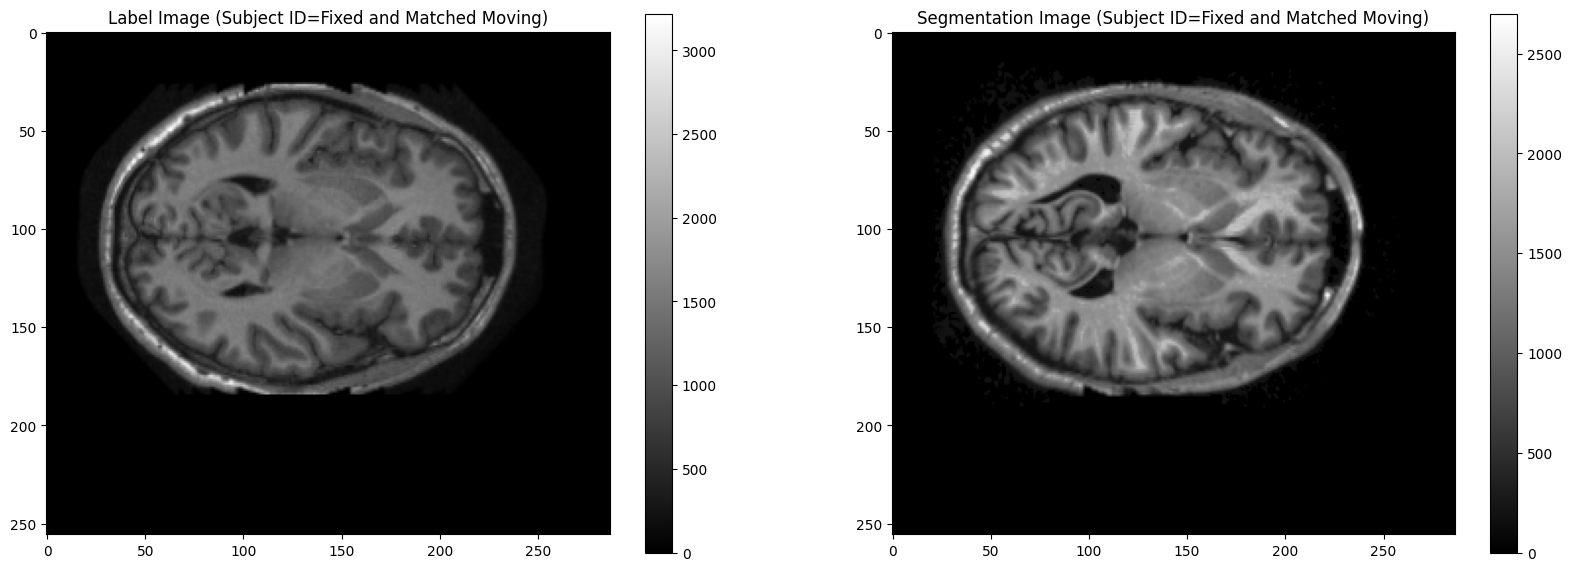

In [43]:
# matched_moving = perform_histogram_matching(fixed, moving)

# print(matched_moving.shape)
# print(mutual_information(matched_moving, fixed))
# print(moving.dtype, np.max(matched_moving), np.min(matched_moving))

# NM.show_label_seg_nifti(fixed, matched_moving, "Fixed and Matched Moving", slice=128)